
## 几种常用的并行训练加速方法-Pytorch


* 1、简单方便的 nn.DataParallel

    https://github.com/tczhangzhi/pytorch-distributed/blob/master/dataparallel.py

* 2、使用 torch.distributed 加速并行训练

    https://github.com/tczhangzhi/pytorch-distributed/blob/master/distributed.py

* 3、使用 torch.multiprocessing 取代启动器

    https://github.com/tczhangzhi/pytorch-distributed/blob/master/multiprocessing_distributed.py

* 4、使用 apex 再加速

    https://github.com/tczhangzhi/pytorch-distributed/blob/master/apex_distributed.py

* 5、使用 horovod 加速

    https://github.com/tczhangzhi/pytorch-distributed/blob/master/horovod_distributed.py
    
* 6、几种并行方式比较：</br>
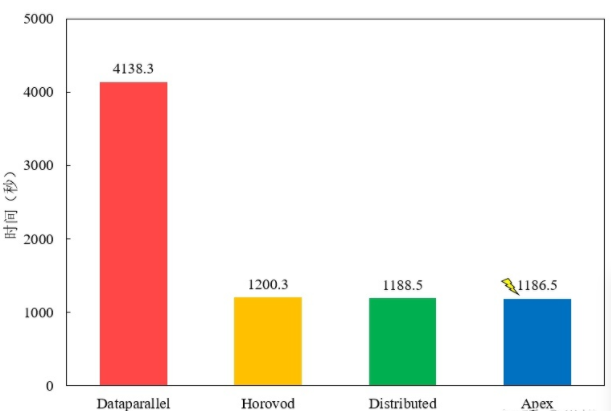
    
* 6、作者出处：https://zhuanlan.zhihu.com/p/98535650

In [ ]:
# 1、使用 nn.DataParallel 加速

# main.py
import torch

gpus = [0, 1, 2, 3]
torch.cuda.set_device('cuda:{}'.format(gpus[0]))

train_dataset = ...

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=...)

model = ...
model = nn.DataParallel(model.to(device), device_ids=gpus, output_device=gpus[0])

optimizer = optim.SGD(model.parameters())

for epoch in range(100):
   for batch_idx, (data, target) in enumerate(train_loader):
      images = images.cuda(non_blocking=True)
      target = target.cuda(non_blocking=True)
      ...
      output = model(images)
      loss = criterion(output, target)
      ...
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
        
        
# 启动方法
# python main.py即可

In [ ]:
# 2、使用 torch.distributed 加速
# main.py
import torch
import argparse
import torch.distributed as dist

# 获取当前GPU进程的index
parser = argparse.ArgumentParser()
parser.add_argument('--local_rank', default=-1, type=int,
                    help='node rank for distributed training')
args = parser.parse_args()

# 设置GPU 之间通信使用的后端和端口
dist.init_process_group(backend='nccl')
torch.cuda.set_device(args.local_rank)

# 使用 DistributedSampler 对数据集进行划分
train_dataset = ...
train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=..., sampler=train_sampler)

# 使用 DistributedDataParallel 包装模型，汇总不同 GPU 算得的梯度，并同步计算结果
model = ...
model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[args.local_rank])

optimizer = optim.SGD(model.parameters())

# 最后把数据和模型加载到当前进程使用的 GPU 中，正常进行正反向传播
for epoch in range(100):
   for batch_idx, (data, target) in enumerate(train_loader):
      images = images.cuda(non_blocking=True)
      target = target.cuda(non_blocking=True)
      ...
      output = model(images)
      loss = criterion(output, target)
      ...
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
        
# 启动方法:
# CUDA_VISIBLE_DEVICES=0,1,2,3 python -m torch.distributed.launch --nproc_per_node=4 main.py

# --nproc_per_node: 单机的进程数，在单机情况下， 只有--nproc_per_node 是必须指定的

In [ ]:
# 使用 torch.multiprocessing 取代启动器
# main.py
import torch
import torch.distributed as dist
import torch.multiprocessing as mp

args = parser.parse_args()
args.nprocs = torch.cuda.device_count()
mp.spawn(main_worker, nprocs=args.nprocs, args=(args.nprocs, args))


def main_worker(local_rank, nprocs, args):
    
   # 由于没有 torch.distributed.launch 读取的默认环境变量作为配置，我们需要手动为 init_process_group 指定参数：
   dist.init_process_group(backend='nccl',init_method='tcp://127.0.0.1:23456',world_size=args.nprocs,rank=local_rank)
   torch.cuda.set_device(args.local_rank)

   train_dataset = ...
   train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset)

   train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=..., sampler=train_sampler)

   model = ...
   model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[args.local_rank])

   optimizer = optim.SGD(model.parameters())

   for epoch in range(100):
      for batch_idx, (data, target) in enumerate(train_loader):
          images = images.cuda(non_blocking=True)
          target = target.cuda(non_blocking=True)
          ...
          output = model(images)
          loss = criterion(output, target)
          ...
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

# 启动方法
# python main.py即可

In [ ]:
# 3、使用 Apex 再加速

# main.py
import torch
import argparse
import torch.distributed as dist

from apex.parallel import DistributedDataParallel

parser = argparse.ArgumentParser()
parser.add_argument('--local_rank', default=-1, type=int,
                    help='node rank for distributed training')
args = parser.parse_args()

dist.init_process_group(backend='nccl')
torch.cuda.set_device(args.local_rank)

train_dataset = ...
train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=..., sampler=train_sampler)

model = ...
model, optimizer = amp.initialize(model, optimizer)
model = DistributedDataParallel(model, device_ids=[args.local_rank])

optimizer = optim.SGD(model.parameters())

for epoch in range(100):
   for batch_idx, (data, target) in enumerate(train_loader):
      images = images.cuda(non_blocking=True)
      target = target.cuda(non_blocking=True)
      ...
      output = model(images)
      loss = criterion(output, target)
      optimizer.zero_grad()
      with amp.scale_loss(loss, optimizer) as scaled_loss:
         scaled_loss.backward()
      optimizer.step()
# 启动 调用 torch.distributed.launch 启动器启动
# UDA_VISIBLE_DEVICES=0,1,2,3 python -m torch.distributed.launch --nproc_per_node=4 main.py

In [ ]:
# 4、使用 Horovod 加速（名字来自于俄国传统民间舞蹈，舞者手牵手围成一个圈跳舞，与分布式 TensorFlow 流程使用 Horovod 互相通信的场景很像。）
# main.py
import torch
import horovod.torch as hvd

# 设置GPU 之间通信使用的后端和端口:
hvd.init()
# 在执行过程中，启动器会将当前进程的（其实就是 GPU的）index 注入 hvd，我们可以这样获得当前进程的 index：
args.local_rank = hvd.local_rank()


train_dataset = ...
# 使用 DistributedSampler 对数据集进行划分。如此前我们介绍的那样，它能帮助我们将每个 batch 划分成几个 partition，在当前进程中只需要获取和 rank 对应的那个 partition 进行训练
train_sampler = torch.utils.data.distributed.DistributedSampler(
    train_dataset, num_replicas=hvd.size(), rank=hvd.rank())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=..., sampler=train_sampler)

model = ...
model.cuda()

optimizer = optim.SGD(model.parameters())

optimizer = hvd.DistributedOptimizer(optimizer, named_parameters=model.named_parameters())

# 使用 broadcast_parameters 包装模型参数，将模型参数从编号为 root_rank 的 GPU 复制到所有其他 GPU 中：
hvd.broadcast_parameters(model.state_dict(), root_rank=0)

# 最后，把数据加载到当前 GPU 中
torch.cuda.set_device(args.local_rank)

for epoch in range(100):
   for batch_idx, (data, target) in enumerate(train_loader):
       images = images.cuda(non_blocking=True)
       target = target.cuda(non_blocking=True)
       ...
       output = model(images)
       loss = criterion(output, target)
       ...
       optimizer.zero_grad()
       loss.backward()
       optimizer.step()

# 启动
# CUDA_VISIBLE_DEVICES=0,1,2,3 horovodrun -np 4 -H localhost:4 --verbose python main.py


### # 分布式 evaluation
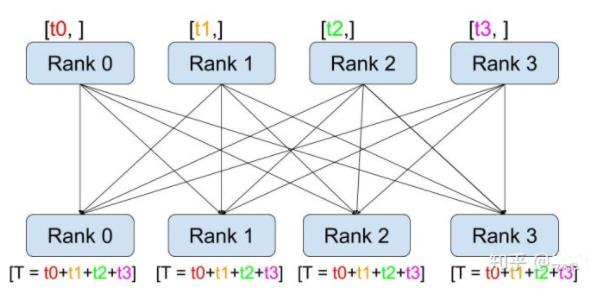

In [ ]:
# 分布式 evaluation
# 原始代码
output = model(images)
loss = criterion(output, target)     
acc1, acc5 = accuracy(output, target, topk=(1, 5))


losses.update(loss.item(), images.size(0))
top1.update(acc1.item(), images.size(0))
top5.update(acc5.item(), images.size(0))

# 修改后，同步各 GPU 中数据切片的统计信息，用于分布式的 evaluation
def reduce_tensor(tensor):
    rt = tensor.clone()
    dist.all_reduce(rt, op=dist.reduce_op.SUM)
    rt /= args.world_size # 表示全局并行进程个数。
    return rt

output = model(images)
loss = criterion(output, target)
acc1, acc5 = accuracy(output, target, topk=(1, 5))

torch.distributed.barrier()

reduced_loss = reduce_tensor(loss.data)
reduced_acc1 = reduce_tensor(acc1)
reduced_acc5 = reduce_tensor(acc5)

losses.update(loss.item(), images.size(0))
top1.update(acc1.item(), images.size(0))
top5.update(acc5.item(), images.size(0))

In [ ]:
# 在 Horovod 中使用

def reduce_mean(tensor, world_size):
    rt = tensor.clone()
    hvd.allreduce(rt, name='barrier')
    rt /= world_size
    return rt
    
output = model(images)
loss = criterion(output, target)
acc1, acc5 = accuracy(output, target, topk=(1, 5))

reduced_loss = reduce_tensor(loss.data)
reduced_acc1 = reduce_tensor(acc1)
reduced_acc5 = reduce_tensor(acc5)

losses.update(loss.item(), images.size(0))
top1.update(acc1.item(), images.size(0))
top5.update(acc5.item(), images.size(0))